In [1]:
import pandas as pd
import numpy as np

#df = pd.read_csv(r"C:\Users\kavya\Desktop\Kavya\Intelihub\client\HERC\Latest\data\model_ready_2.csv")

In [2]:
df = pd.read_csv(r"C:\Users\HP\Documents\Load_Forecasting_using_Fbprophet\Final Files fbprophet\Combined_Data_for_model_final_2.csv")

In [3]:
del df['Unnamed: 0']

#### Extracting Cal Features

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df = df[df['Date']>='2018-01-01']

In [8]:
df1 = df[df['Date'] < '2020-03-01']

In [9]:
df2 = df[df['Date'] > '2020-04-30']

In [10]:
df3 = df1.append(df2)

In [12]:
df_covidless = df3

In [13]:
df_covidless.to_csv('df_covidless.csv')

In [14]:
df = df_covidless

In [15]:
df['month'] = pd.to_datetime(df['Date']).dt.month
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday
df['hour'] = pd.to_datetime(df['Date']).dt.hour
df['hour_part'] = pd.to_datetime(df['Date']).dt.minute
df['year'] = pd.to_datetime(df['Date']).dt.year
df['day'] = pd.to_datetime(df['Date']).dt.day

# remove outliers in windspeed - checked the max windspeed India recorded - it is around 100
df = df[df['windspeed']<=100]

<AxesSubplot:>

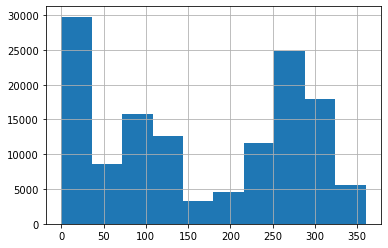

In [16]:
df['winddir'].hist()

In [17]:
def get_season(TimeSeries):
    
    season_list = []
    
    year_list = []
    month_list = []
    for time in TimeSeries:
        year = str(time)[:4]
        month = str(time)[5:7]
        year_list.append(year)
        month_list.append(month) 
       
    for m in month_list:
        if m=='01' or m=='02' or m=='12':
            season_list.append(0)   # Winter
        elif m=='03' or m=='04' or m=='05':
            season_list.append(1) #Spring-Summer
        elif m == '06' or m=='07':
            season_list.append(2) #Paddy/Monsoon
        elif m=='08' or m=='09':
            season_list.append(3) #Late Monsoon
        elif m=='10' or m=='11':
            season_list.append(4) #Autumn
            
    #season = pd.Series(season_list)
    return season_list

In [18]:
season = get_season(df['Date'])

In [19]:
df['Season'] = season

C:\Users\HP\AppData\Local\Temp/ipykernel_11132/3332413871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = season


In [20]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import StratifiedKFold
import itertools
# from skopt import BayesSearchCV as bayes_opt

In [21]:
# check for 0 values and remove
df = df[df['Haryana Load (MW)']>0]

In [22]:
# Train Data
train = df[df['Date']<="2021-06-01"]

In [23]:
# Test Data
test = df[df['Date']>"2021-06-01"]

In [24]:
x_train = train[['month', 'hour', 'weekday', 'temp',
       'humidity', 'winddir', 'visibility', 'cloudcover',
       'hour_part', 'day', 'Season']]
y_train = train[['Haryana Load (MW)']]

In [25]:
x_test = test[['month', 'hour', 'weekday', 'temp',
       'humidity', 'winddir', 'visibility', 'cloudcover',
       'hour_part', 'day', 'Season']]
y_test = test[['Haryana Load (MW)']]

In [26]:
x_test.describe()

,month,hour,weekday,temp,humidity,winddir,visibility,cloudcover,hour_part,day,Season
count,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000
mean,9.004819,11.500560,2.990751,26.290746,72.787525,144.249331,2.849107,44.337088,22.501095,15.790440,2.565448
std,1.998813,6.922058,1.988310,7.092862,19.693465,112.560636,1.105441,35.743741,16.770591,8.827231,1.298122
min,6.000000,0.000000,0.000000,5.000000,19.570000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,6.000000,1.000000,21.400000,58.110000,40.000000,2.000000,0.000000,15.000000,8.000000,2.000000
50%,9.000000,12.000000,3.000000,28.000000,77.140000,120.000000,3.000000,50.000000,30.000000,16.000000,3.000000
75%,11.000000,17.500000,5.000000,31.000000,88.920000,260.000000,4.000000,86.500000,37.500000,23.000000,4.000000
max,12.000000,23.000000,6.000000,43.000000,100.000000,360.000000,9.000000,100.000000,45.000000,31.000000,4.000000


In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [28]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
preds = model.predict(x_test)

In [30]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_11132/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [31]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7239651410708295

##### R2 = 0.727

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
regr = RandomForestRegressor()

In [34]:
regr.fit(x_train, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_11132/1990009532.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x_train, y_train)


RandomForestRegressor()

In [35]:
preds = model.predict(x_test)

In [36]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_11132/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [37]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7239651410708295

##### Error Analysis

In [22]:
test['pred'] = preds
test['error'] = test['Haryana Load (MW)'] - test['pred']

<ipython-input-22-a86ab4d612e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = preds
<ipython-input-22-a86ab4d612e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = test['Haryana Load (MW)'] - test['pred']


<AxesSubplot:xlabel='Date'>

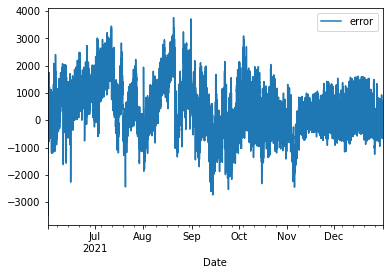

In [23]:
test.plot(x='Date',y='error')

 We see there is abnormality in the months of july, aug, sep.

In [ ]:
test.head()

In [24]:
# Feature Importance
model.get_booster().get_score(importance_type='gain')

{'temp': 296806968.47466606,
 'hour': 73028803.9954666,
 'cloudcover': 26817949.52511701,
 'month': 269262282.0976934,
 'day': 30060776.518135272,
 'humidity': 16929007.078289542,
 'weekday': 24446736.83493143,
 'visibility': 16389417.130703814,
 'winddir': 9512341.559754401,
 'hour_part': 3649928.4209017446}

In [26]:
test['temp_buckets'] = pd.cut(test['temp'],bins=10)

<ipython-input-26-7e3f680c35f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['temp_buckets'] = pd.cut(test['temp'],bins=10)


##### Temperature being top imprtant feature - chewcking the avg error based on temp buckets

In [27]:
test.groupby(['temp_buckets'])['error'].mean()

temp_buckets
(4.962, 8.8]     -77.538807
(8.8, 12.6]       84.004956
(12.6, 16.4]     124.500015
(16.4, 20.2]      -9.037472
(20.2, 24.0]     128.152045
(24.0, 27.8]     351.041139
(27.8, 31.6]     496.247888
(31.6, 35.4]     804.240359
(35.4, 39.2]    1084.552221
(39.2, 43.0]    1371.174095
Name: error, dtype: float64

##### model is not performing well on data where high temperatures are recoded 

In [25]:
# Checking the mean error based on hour of day
test.groupby(['hour'])['temp','error'].mean()

<ipython-input-25-b73c37299601>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test.groupby(['hour'])['temp','error'].mean()


,temp,error
hour,,
0,24.494035,525.554312
1,24.143925,494.817999
2,23.502804,403.877058
3,23.559346,445.741741
4,23.200935,416.031822
5,22.666355,261.768627
6,22.890654,296.419949
7,23.345327,461.678909
8,24.169159,586.047841


<AxesSubplot:xlabel='month', ylabel='error'>

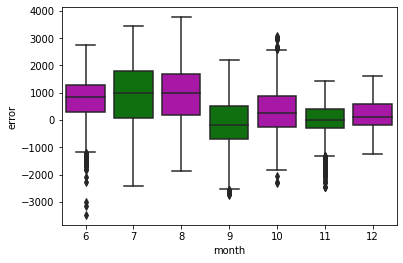

In [28]:
import seaborn as sns
sns.boxplot(x="month", y="error", palette=["m", "g"],
            data=test)

In [ ]:
'''
x_ = []
y_ = []
for month in range(1,30):
    data = test[test['day']==month]
    r2 = r2_score(data['Haryana Load (MW)'],data['pred'])
    x_.append(month)
    y_.append(r2)
    print(r2,month)
plot_df = pd.DataFrame({"x":x_,"y":y_})
plot_df.plot(x="x",y="y")
'''